In [14]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

telemetry-pure-pursuit.csv
max RPM: 16201.4648239


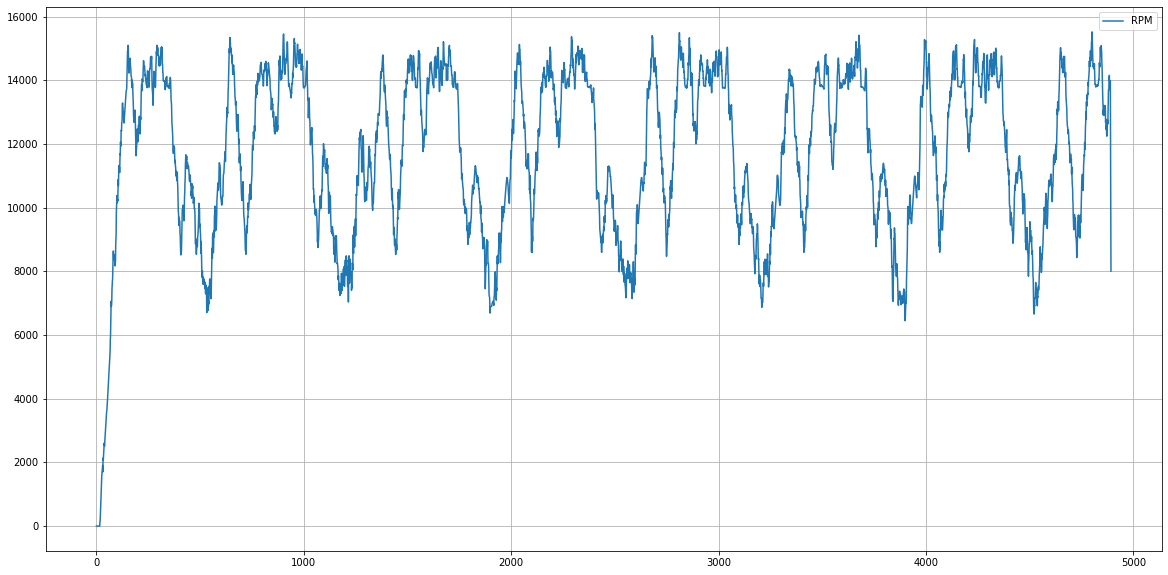

No handles with labels found to put in legend.


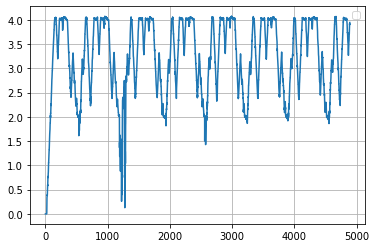

In [15]:
max_rpm = 0

input_files = ["telemetry-pure-pursuit.csv"]
csvs = []
period = 7
for file in input_files:
    print(file)
    csv = pd.read_csv(file)
    max_rpm = max(max_rpm, max(csv["motor_rpm"]))
    csv["motor_rpm"] = np.convolve(csv["motor_rpm"], np.ones((period,)) / period, mode='same')
    csvs += [csv]
    
print("max RPM: {}".format(max_rpm))
    
for csv in csvs:    
    plt.figure(figsize=(20, 10))
    plt.grid()
    #plt.plot(csv["throttle_input"], label="throttle")
    #plt.plot(csv["steering_angle_input"], label="steering angle")
    plt.plot(csv["motor_rpm"], label="RPM")
    plt.legend()
    plt.show()
    
    plt.grid()
    #plt.plot(csv["throttle_input"], label="throttle")
    #plt.plot(csv["steering_angle_input"], label="steering angle")
    plt.plot(csv["speed"])
    plt.legend()
    plt.show()

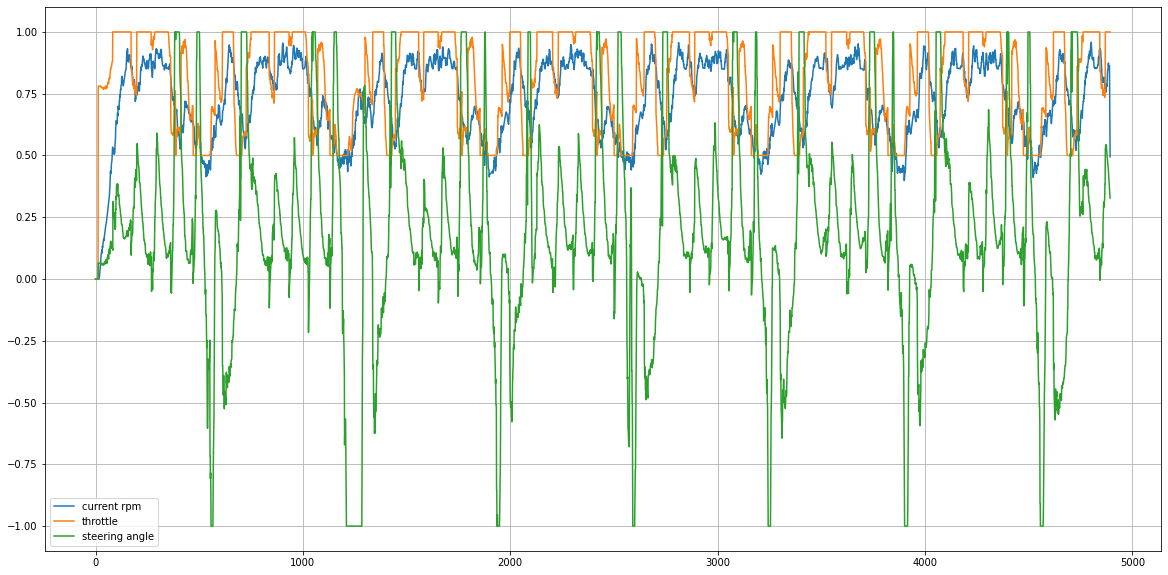

In [16]:
# I want the intput to be in the form of:
# (current RPM, throttle input, steering input, RPM change rate)

import numpy as np

data = np.array(np.zeros(4))

for csv in csvs:
    previous_rpm = 0
    for index, row in csv.iterrows():
        next_rpm = row["motor_rpm"] / max_rpm       
        previous_rpm = next_rpm
        
        record = [previous_rpm, row["throttle_input"], row["steering_angle_input"], next_rpm]
        
        data = np.vstack((data, record))

plt.figure(figsize=(20, 10))
plt.grid()
plt.plot(data[:, 0], label="current rpm")
plt.plot(data[:, 1], label="throttle")
plt.plot(data[:, 2], label="steering angle")
plt.legend()
plt.show()

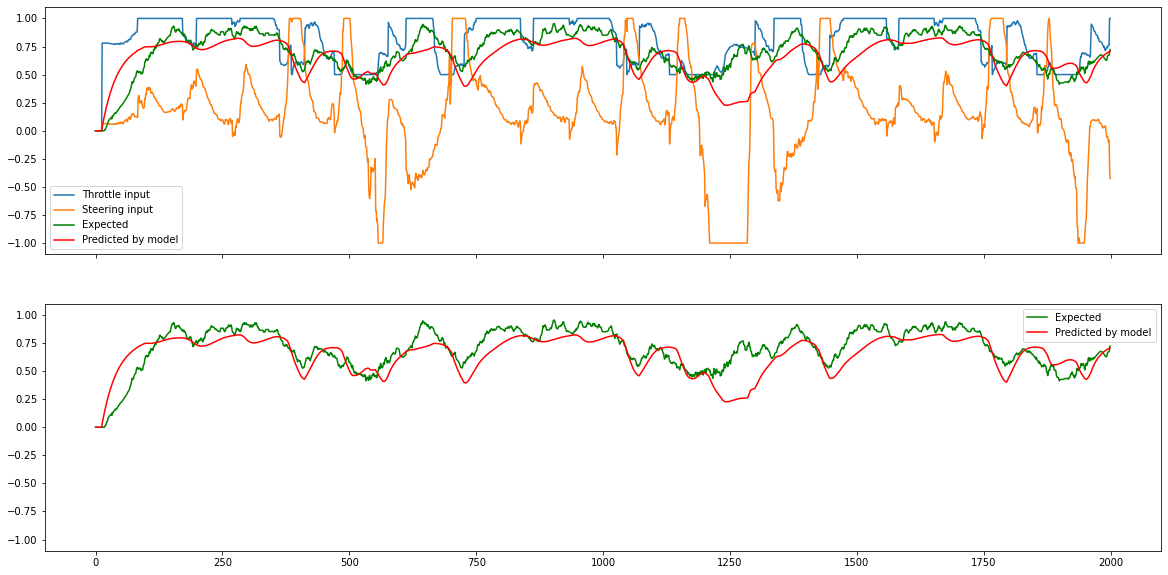

In [17]:
import math
max_rpm_normalized = 1.0

def torque(rpm, stall_torque):
    return (1 - rpm) * stall_torque

def predict_torque(rpm, throttle, steering, x):
    drive_torque = torque(rpm, x[0]) * throttle
    load_torque = (rpm ** x[2]) * ((x[3] + x[4] * abs(steering)) ** x[5])

    return (drive_torque - load_torque) / x[1]

dt = 1./25.
        
def predict_custom(offset, n, x):
    rpm = float(data[offset, 0])
    for row in data[offset:(offset + n)]:   
        motor_rpm_acc = predict_torque(rpm, row[1], row[2], x)        
        rpm = max(0, rpm + motor_rpm_acc * dt)
        yield rpm
        
o = 0
l = 2000
x = [7.99889787e+02, 8.00123797e+02, 1.51154446e-02, 5.83921900e+00,
     3.79599215e+00, 2.68911294e+00]
predicted = np.array(list(predict_custom(o, l, x)))

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(20, 10))

ax0.plot(data[o:(o+l),1], label="Throttle input")
ax0.plot(data[o:(o+l),2], label="Steering input")
ax0.plot(data[o:(o+l),3], 'g', label="Expected")
ax0.plot(predicted, 'r', label="Predicted by model")
ax1.plot(data[o:(o+l),3], 'g', label="Expected")
ax1.plot(predicted, 'r', label="Predicted by model")
ax1.legend()
ax0.legend()
plt.show()


In [18]:
# max_rpm = 18000

# csvs = []
# period = 7
# csv = pd.read_csv("./telemetry.csv")

# # max_rpm = max(csv["rpm"])
# csv["motor_rpm"] = np.convolve(csv["motor_rpm"], np.ones((period,)) / period, mode='same')
# csvs += [csv]
    
# print("max RPM: {}".format(max_rpm))
# print("top RPM: {}".format(max(csv["motor_rpm"])))
    
# plt.figure(figsize=(20, 10))
# plt.grid()
# plt.plot(csv["throttle_input"], 'b.', label="throttle")
# plt.plot(csv["steering_angle_input"], label="steering angle")
# plt.plot(csv["motor_rpm"] / max_rpm, label="RPM")
# plt.legend()
# plt.show()

# data = np.array(np.zeros(4))

# previous_rpm = 0
# for index, row in csv.iterrows():
#     next_rpm = row["motor_rpm"] / max_rpm       
#     previous_rpm = next_rpm

#     record = [previous_rpm, row["throttle_input"], row["steering_angle_input"], next_rpm]

#     data = np.vstack((data, record))

In [19]:
from scipy.optimize import minimize, differential_evolution

# def err(x):
#     err = 0
#     offset = 0
#     for csv in csvs:
#         predicted = predict_custom(offset, len(csv), x)
#         offset += len(csv)
#         for (pred, ref) in zip(predicted, data):
#             err += (pred - ref[3]) ** 2
#         return err

def err(x):
    err = 0
    offset = 0
    predicted = predict_custom(offset, len(csv), x)
    offset += len(csv)
    for (pred, ref) in zip(predicted, data):
        err += (pred - ref[3]) ** 2
    return err



# minimize(method=’Nelder-Mead’)
# minimize(method=’Powell’)
# minimize(method=’CG’)
# minimize(method=’BFGS’) - so far the best results
# minimize(method=’Newton-CG’) - nope
# minimize(method=’L-BFGS-B’) - nope
# minimize(method=’TNC’)
# minimize(method=’COBYLA’)
# minimize(method=’SLSQP’)
# minimize(method=’trust-constr’)
# minimize(method=’dogleg’)
# minimize(method=’trust-ncg’)
# minimize(method=’trust-krylov’)
# minimize(method=’trust-exact’)

x0 = [1.46146542e+02, 1.35840204e+03, 9.67287713e-01, 1.01098231e+00,
 1.75427529e-02, 1.77176445e+02]

bnds = ((-100, 100), (-100, 100), (-100, 100), (-100, 100), (-100, 100), (-100, 100))
res = minimize(err, x0, method='BFGS', bounds=bnds).x
# res = differential_evolution(err, bnds).x

print(res)


/home/simon/.local/lib/python3.6/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


[3.89298586e+02 1.34042231e+03 1.10378535e+01 1.00391002e+00
 1.30939911e-02 6.95898649e+02]


[3.89298586e+02 1.34042231e+03 1.10378535e+01 1.00391002e+00
 1.30939911e-02 6.95898649e+02]
top rpm: 14921.59904535979


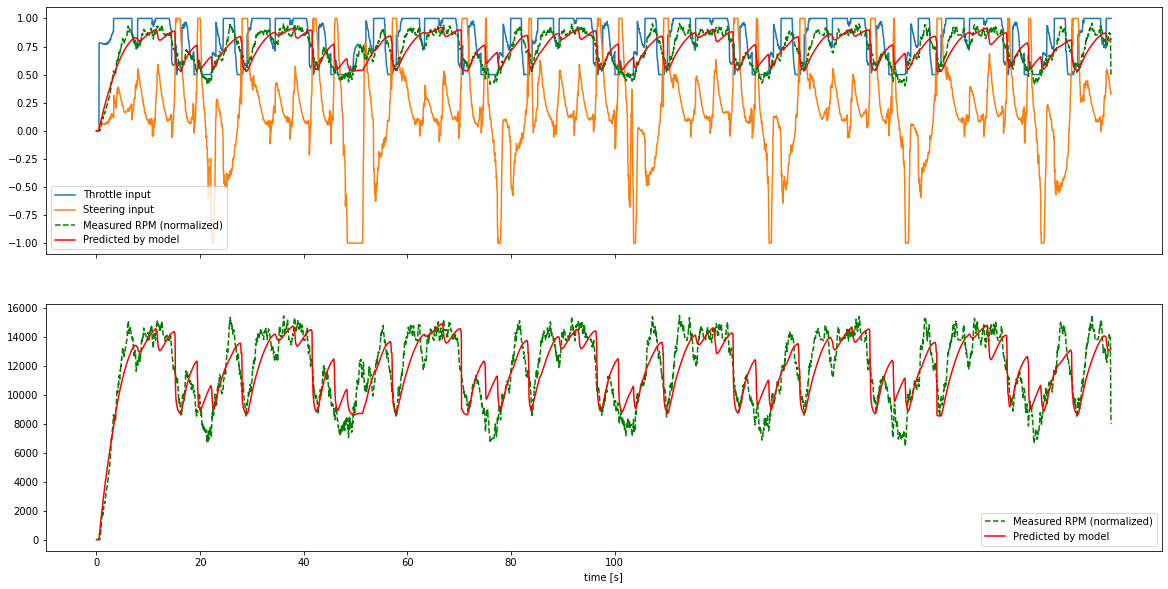

In [24]:
l = len(data)
o = 0

print(res)

# for csv in csvs:
#     o += l
#     l = len(csv)
predicted = np.array(list(predict_custom(o, l, res)))
top_rpm = max(predicted)
print("top rpm: {}".format(top_rpm * max_rpm))

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))

ax0.plot(data[o:(o+l),1], label="Throttle input")
ax0.plot(data[o:(o+l),2], label="Steering input")
ax0.plot(data[o:(o+l),3], 'g--', label="Measured RPM (normalized)")
ax0.plot(predicted, 'r', label="Predicted by model")

ax1.plot(data[o:(o+l),3] * max_rpm, 'g--', label="Measured RPM (normalized)")
ax1.plot(predicted * max_rpm, 'r', label="Predicted by model")
ax1.legend()

ax0.legend()

plt.xlabel("time [s]")
plt.xticks([0, 500, 1000, 1500, 2000, 2500], [0, 20, 40, 60, 80, 100])

plt.show()
# plt.savefig("fit_{}.pdf".format(o));